<div style="text-align:right" align="right"><i>Peter Norvig<br>Oct. 2021</i></div>

# Solving Sudoku at 100,000 puzzles per second

The rules of [**Sudoku**](http://en.wikipedia.org/wiki/Sudoku) are simple and finite:  fill in the empty squares so that each column, row, and 3x3 box contains all the digits from 1 to 9.

|Puzzle|Solution|
|---|---|
|![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/Sudoku_Puzzle_by_L2G-20050714_standardized_layout.svg/361px-Sudoku_Puzzle_by_L2G-20050714_standardized_layout.svg.png)|![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/12/Sudoku_Puzzle_by_L2G-20050714_solution_standardized_layout.svg/361px-Sudoku_Puzzle_by_L2G-20050714_solution_standardized_layout.svg.png)|


In 2006, I wrote a [Python program](http://norvig.com/sudoku.html) to solve [**Sudoku**](http://en.wikipedia.org/wiki/Sudoku). Soon after that,  [Peter Seibel](https://gigamonkeys.com/) invited me to publish an article  in [*Code Quarterly*](https://gigamonkeys.com/code-quarterly/) magazine which would go into more detail about backtracking search and constraint propagation in general, and would feature a  more efficient  program. Unfortunately, the magazine [folded](https://gigamonkeys.wordpress.com/2011/10/17/end-of-the-line-for-code-quarterly/) before I could finish the article. In 2021 I [updated the Python Sudoku program](Sudoku.ipynb) to Jupyter notebook form, with modern coding idioms, and now I do the same for the [more efficient Java Sudoku program](Sudoku.java). (I apologize for some remaining legacy Java idioms from decades ago).

The [Java program](Sudoku.java) is similar to the [Python program](Sudoku.ipynb) in many ways:

- They both represent a puzzle as a **grid** of 81 squares, with 27 **units** (9 rows, 9 columns, 9 boxes).
- They both represent uncertainty about a square's contents with a **set** of the possible digits from 1 to 9.
- They both do a depth-first [search](http://en.wikipedia.org/wiki/Search_algorithm) for a solution.
  - They find an unfilled square with the fewest remaining possible digits, guess a digit to fill the square, and try to solve the rest of the puzzle from there. If that fails, back up and try a different guess for the square.
  - Each guess is placed on a new *copy* of the board. If the guess turns out to be wrong, revert to the old board.
- They both use [constraint propagation](http://en.wikipedia.org/wiki/Constraint_satisfaction) to limit the search:
  - *The one rule:* After filling a square with a digit, eliminate the digit from all of the square's [peers](https://www.sudocue.net/guide.php#peers).
  - *Arc consistency:* after eliminating a possible digit from a square, check that it still has some other possible digit.
  - *Dual consistency:* after eliminating a possible digit from a square, check that another square in each of the square's 3 units could hold that digit.
  - These changes do not require a new copy of the board, because they are logical consequences, not guesses.
  - If a check fails, back up a level in the search.


The [Python program](http://norvig.com/sudoku.html) was written for clarity and brevity; the [Java program](Sudoku.java) for efficiency. In particular:
- Primitive Java data types are used:
  - A grid is an `int[81]` array, not a hash table (dict). 
  - A square is an int (like `8`), not a string (like `'A9'`).
  - A set of possible digits  is an int bitset (like `0b110010100`) not a string of digits (like `'9853'`). 
- Multiple puzzles are solved in parallel, in different threads.
- Rather than allocating (and then garbage collecting) a new copy of the grid at each step in the depth-first search, instead  we pre-allocate a `gridpool` array of grids once and for all (at the start of each thread), and then every recursive call to `search` re-uses `gridpool[level]`. 
- The specific Sudoku strategy of [naked pairs](https://www.learn-sudoku.com/naked-pairs.html) is implemented.
- Java is inherently faster than Python.
    

# Command Line Options

Here are the options for the `java Sudoku` command:

In [1]:
!java Sudoku -help

usage: java Sudoku -(no)[fghnprstuv] | -[RT]<number> | <filename> ...
E.g., -v turns verify flag on, -nov turns it off. -R and -T require a number. The options:

  -f(ile)    Print summary stats for each file (default on)
  -g(rid)    Print each puzzle grid and solution grid (default off)
  -h(elp)    Print this usage message
  -n(aked)   Run naked pairs (default on)
  -p(uzzle)  Print summary stats for each puzzle (default off)
  -r(everse) Solve the reverse of each puzzle as well as each puzzle itself (default off)
  -s(earch)  Run search (default on, but some puzzles can be solved with CSP methods alone)
  -t(hread)  Print summary stats for each thread (default off)
  -u(nitTest)Run a suite of unit tests (default off)
  -v(erify)  Verify each solution is valid (default on)
  -T<number> Concurrently run <number> threads (default 26)
  -R<number> Repeat each puzzle <number> times (default 1)
  <filename> Solve all puzzles in filename, which has one puzzle per line


# Benchmark Puzzles

I gathered a collection of puzzles from various sources. I then added variants by permuting digits or rows of a puzzle (e.g. given a valid puzzle, if you swap the first and second row, or swap each 3 with each 7, you still have a valid puzzle). I ended up with exactly 250,000 puzzles:

In [2]:
!wc sudoku.txt

  250000  250000 20500000 sudoku.txt


Below are the first 10  (the 9 rows of a puzzle are all run together on a line; a dot represents an empty square):

In [3]:
!head sudoku.txt

..7........1....3..5..4.6...4....7...6...3........1..2.....7.......6..8...2.....1
..3..2.8.14......9.68.593.7..24.5...............2.85..9.457.86.6......75.8.6..4..
.....4.....5.....3...8.1.6.......81..73........2..6.......2....14...........5...7
......8..3...6.9.71.8.9..6..673...2....2.6....2...938..3..8.1.25.267...8..9......
......7.4.1.5......6..........15.9..8.....3.....6.....4...97.....7..8..........1.
..2..6..7......8.9.8..4..6.85.2..93.....3.....93..1.25.1..9..5.5.4......2..3..6..
.....8......6.4.........1.7....9......5.....36......84..7.......4.....6.....269..
....1......4....6....85............289............7.34.........15....8....3..4..7
...9.........1..7..9...4.2..4.16.....5.3......1...7.533......1....58..4.8.....2..
.......8...4....15..23.7........3...8.......1.....2..6........4....1.....26...7..


# Sample Puzzle Solution

Here is one puzzle and its solution:

In [4]:
!java Sudoku -grid -nofile one.txt


Puzzle 1:                   Solution:
. . 7 | . . . | . . .       6 9 7 | 5 3 8 | 1 2 4 
. . 1 | . . . | . 3 .       4 2 1 | 7 9 6 | 8 3 5 
. 5 . | . 4 . | 6 . .       3 5 8 | 1 4 2 | 6 7 9 
------+-------+------       ------+-------+------
. 4 . | . . . | 7 . .       1 4 3 | 8 2 9 | 7 5 6 
. 6 . | . . 3 | . . .       2 6 5 | 4 7 3 | 9 1 8 
. . . | . . 1 | . . 2       8 7 9 | 6 5 1 | 3 4 2 
------+-------+------       ------+-------+------
. . . | . . 7 | . . .       5 8 6 | 2 1 7 | 4 9 3 
. . . | . 6 . | . 8 .       9 1 4 | 3 6 5 | 2 8 7 
. . 2 | . . . | . . 1       7 3 2 | 9 8 4 | 5 6 1 


# Latency versus Throughput

There are two measures of the efficiency of a program:
1. **Latency** is the time it takes to solve a single puzzle.
2. **Throughput** is the number of puzzles that can be solved in a given amount of time.

These measures would amount to the same thing if there were only one processor available, but if, say, there are 10 processors working in parallel with no overhead and each puzzle takes 1 second to solve, then latency would be 1 second but throughput would be 10 puzzles per second.

# Benchmark Timing Statistics

Let's run the program and print two lines of summary timing statistics: one line for the 250,000 puzzles in `sudoku.txt`, and one line where the  `-r` option specifies that the reverse of each puzzle is also solved (the last square becomes the first, etc.), and the  `-R2` option specifies that each puzzle is repeated twice, for a total of  2 × 2 × 250,000 = a million puzzles.  (The idea is that there will be less variance if there are more puzzles to solve, and also that the effect of any JIT cache warmup period will be lessened.) 

In [5]:
!java Sudoku sudoku.txt -r -R2 sudoku.txt 

Puzzles   μsec     KHz Threads Backtracks Name
======= ====== ======= ======= ========== ====
 250000   10.7  93.400      26       30.3 sudoku.txt
1000000    8.5 117.781      26       31.4 sudoku.txt


We solved a million puzzles with a throughput of **over 100,000 puzzles per second**. Not too shabby! 

The columns of the output are:

- `Puzzles`: the total number of puzzles solved.
- `μsec`: the throughput expressed as average time to solve a puzzle in microseconds (millionths of a second).
- `KHz`: the throughput expressed as thousands of puzzles solved per second.
- `Threads`: the number of concurrent threads.
- `Backtracks`: the average number of times per puzzle that the search guessed wrong and had to back up.
- `Name`: here the name of the file; could also be the name of a thread or puzzle.

To determine the latency, use the `-T1` option to request a single thread:

In [6]:
!java Sudoku -T1 sudoku.txt

Puzzles   μsec     KHz Threads Backtracks Name
======= ====== ======= ======= ========== ====
 250000   98.5  10.148       1       34.2 sudoku.txt


The average latency is about 100 μsec (or 1/10,000th of a second).

# Effect of Number of Threads

I'm running these benchmarks on a [10-core Intel Comet Lake core i9 processor](https://everymac.com/systems/apple/imac/specs/imac-core-i9-3.6-10-core-27-inch-retina-5k-2020-20-2-specs.html) with [hyperthreading](https://www.intel.com/content/www/us/en/gaming/resources/hyper-threading.html) that allows 20 threads to run at once. So I expected that peak throughput would be at 20 threads–any more than that, and there would be overhead of swapping threads in and out. Let's look at this plot of throughput  versus number of threads:

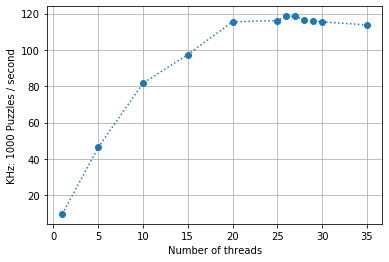

In [7]:
import matplotlib.pyplot as plt

# Previously-collected {number_of_threads: KHz} data
T = {1:    9.760,  5:  46.362, 10:  81.680, 15:   97.457, 20: 115.467, 25: 116.169, 
     26: 118.546, 27: 118.524, 28: 116.736, 29: 116.013, 30: 115.467, 35: 113.780}

plt.plot(list(T), list(T.values()), 'o:'); plt.grid()
plt.xlabel('Number of threads'); plt.ylabel('KHz: 1000 Puzzles / second');

It looks like there is a plateau between 20 and 30 threads: they all have about the same throughput, with  a slight peak at 26 or 27 threads. Why doesn't throughput start to go down after 20 threads? The program works by dividing up the puzzles into fixed-size shards and handing a shard to each thread. If it happens that one thread gets a particularly easy shard of puzzles, then it will terminate early. With 20 threads, that would mean that part of the CPU would become idle with no more work to do. With a few more than 20 threads, there would be an extra thread ready to be swapped in when the easy thread(s) terminate early. Apparently the advantage of that outweights the disadvantage of having to swap some threads in and out. Of course, the computer is also running a few threads to keep the Jupyter notebook, the browser, the display, the network, and other things up and running.

# Effect of Naked Pairs Strategy

The Java program explicitly uses the [naked pairs strategy](https://www.learn-sudoku.com/naked-pairs.html) to eliminate some possible digits, whereas the Python program would have to make guesses to get the same solution. We can check how much the naked pairs strategy helps by disabling it with the `-nonaked` option:

In [8]:
!java Sudoku -r -R2 sudoku.txt -nonaked sudoku.txt

Puzzles   μsec     KHz Threads Backtracks Name
======= ====== ======= ======= ========== ====
1000000    9.1 109.824      26       30.7 sudoku.txt
1000000   14.3  70.025      26       94.9 sudoku.txt


It makes a noticable difference: throughput decreases from 110 KHz to 70 KHz without it. Perhaps implementing [other strategies](https://bestofsudoku.com/sudoku-strategy) could give similar speedups. However, my feeling is that the program is already fast enough, and there would probably be diminishing returns from further strategies.

# Hardest(?) Puzzles

Here is a collection of 10 puzzles that have been nominated as "hardest":

In [9]:
!cat hardest.txt

85...24..72......9..4.........1.7..23.5...9...4...........8..7..17..........36.4.
..53.....8......2..7..1.5..4....53...1..7...6..32...8..6.5....9..4....3......97..
12..4......5.69.1...9...5.........7.7...52.9..3......2.9.6...5.4..9..8.1..3...9.4
...57..3.1......2.7...234......8...4..7..4...49....6.5.42...3.....7..9....18.....
1....7.9..3..2...8..96..5....53..9...1..8...26....4...3......1..4......7..7...3..
1...34.8....8..5....4.6..21.18......3..1.2..6......81.52..7.9....6..9....9.64...2
...92......68.3...19..7...623..4.1....1...7....8.3..297...8..91...5.72......64...
.6.5.4.3.1...9...8.........9...5...6.4.6.2.7.7...4...5.........4...8...1.5.2.3.4.
7.....4...2..7..8...3..8.799..5..3...6..2..9...1.97..6...3..9...3..4..6...9..1.35
....7..2.8.......6.1.2.5...9.54....8.........3....85.1...3.2.8.4.......9.7..6....


We can compare performance of these puzzles with the benchmark puzzles. To keep things fair, use 20 threads for both (with reversed puzzles included, that's 20 "hardest" puzzles, so 1 per thread) and 500,000 total puzzles for both:

In [10]:
!java Sudoku -r -T20 -R25000 hardest.txt -R1 sudoku.txt 

Puzzles   μsec     KHz Threads Backtracks Name
======= ====== ======= ======= ========== ====
 500000   14.0  71.562      20       10.4 hardest.txt
 500000    9.0 111.215      20       31.4 sudoku.txt


This suggests these puzzles are indeed harder than average, by roughly 50%. One interesting point  is that the number of backtracks is below average for the "hardest" puzzles. 

I can get timing and backtrack data for individual puzzles with the `-p` option:

In [11]:
!java Sudoku -r -T1 -p hardest.txt

Puzzles   μsec     KHz Threads Backtracks Name
======= ====== ======= ======= ========== ====
      1  598.9   1.670       1        1.0 Puzzle 1
      1  172.2   5.807       1        6.0 Puzzle 2
      1  212.7   4.702       1       13.0 Puzzle 3
      1  182.9   5.467       1       12.0 Puzzle 4
      1  109.1   9.170       1        0.0 Puzzle 5
      1  172.3   5.803       1        8.0 Puzzle 6
      1  194.5   5.142       1        6.0 Puzzle 7
      1  213.2   4.690       1        9.0 Puzzle 8
      1  265.2   3.771       1       11.0 Puzzle 9
      1  631.3   1.584       1       79.0 Puzzle 10
      1  147.9   6.763       1        1.0 Puzzle 11
      1  110.4   9.057       1        0.0 Puzzle 12
      1  113.8   8.788       1        0.0 Puzzle 13
      1  125.1   7.996       1        3.0 Puzzle 14
      1  125.2   7.987       1        1.0 Puzzle 15
      1  120.3   8.309       1        0.0 Puzzle 16
      1  126.0   7.938       1        2.0 Puzzle 17
      1  104.1   9.609       1 

A few puzzles take about half a millisecond each; the other puzzles are faster. Overall, I think the claim of "hardest" is overblown.

# Distribution of Puzzle Difficulty

What's the distribution of puzzle run times across the benchmark puzzles? Of number of backtracks?

I can get data  for individual puzzles with the `-p` option, then eliminate the header lines with `fgrep "."`, then [cut](https://linuxize.com/post/linux-cut-command/) out just the characters of each line that denote the μsec and Backtracks columns. The following line does that, but it is commented out for now because the output is already captured in `sudata.txt` and does not need to be generated again.

In [12]:
#!java Sudoku -T1 -r -nofile hardest.txt -p Sudoku.txt | fgrep "." | cut -c8-15 -c31-39 > sudata.txt

Next, load the data into a pandas dataframe and describe it:

In [13]:
import pandas as pd
sudata = pd.read_csv('sudata.txt', delim_whitespace=True, names=['μsec', 'backtracks'])
sudata.describe()

,μsec,backtracks
count,500000.000000,500000.000000
mean,94.786948,32.050252
std,226.471924,152.089871
min,34.500000,0.000000
25%,43.500000,1.000000
50%,53.100000,4.000000
75%,81.500000,18.000000
max,22856.310000,8145.000000


The mean latency is a bit under 100 microseconds, the median is 53.1 microseconds, and the maximum is about 23,000 microseconds, or 1/40th of a second. For backtracks, the mean is 32, the median is only 4, and the maximum is over 8,000. 

It may help to look at a scatterplot:

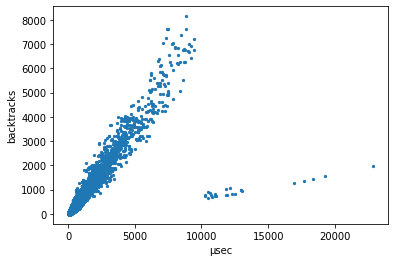

In [14]:
sudata.plot.scatter(y='backtracks', x='μsec', marker='.');

**Wow! That's unusual!** I expected the comet-tail-shaped cluster to the left, but I did ***not*** expect the small cluster of outlier points in the lower right corner (all with 10000+ μsec and 500—2000 backtracks).  

Let's look at the outliers more closely:

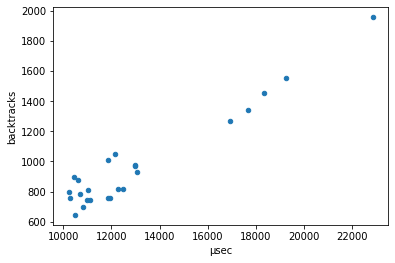

In [15]:
outliers = sudata[sudata['μsec'] > 10_000]

outliers.plot.scatter(y='backtracks', x='μsec', marker='o');

In [16]:
outliers.describe()

,μsec,backtracks
count,24.000000,24.000000
mean,13059.210000,976.000000
std,3374.607334,319.690339
min,10230.310000,645.000000
25%,10789.560000,760.000000
50%,11910.210000,849.000000
75%,12998.510000,1021.250000
max,22856.310000,1957.000000


Only 24 puzzles in total take more than 10 milliseconds; only 5 are over 14 milliseconds; only 1 is over 20 milliseconds. I was worried there was going to be a long tail of times, and clearly this is not a normal distribution, but neither does it seem to be a distribution where the long tail just keeps on going forever. If I solved another million random puzzles I would not be surprised to find a puzzle that doubles the maximum run time, but I would be surprised to find one that increases the run time by a factor of 10.

Within the outliers, backtracks correlate very highly with run time (just as with the non-outliers). But as a whole, the outliers take more run time than any of the other 500,000 puzzles and have far fewer backtracks than any other puzzles with comparable run times. 

I'm imaging that when solving the outliers, the solution takes a step, then has a long chain of constraint propagation only to find a contradiction at the very end, then backs up and takes another step. But I don't really understand the mystery of these outliers. 

Here are all of them:

In [17]:
outliers

,μsec,backtracks
7803,16931.41,1269
8828,10820.31,700
13143,12979.51,973
78290,12495.71,819
106137,10697.31,785
121433,10497.51,645
129467,10274.61,756
145734,11011.01,746
174777,12974.81,972
183889,22856.31,1957


One weakness of a scatter plot as a visualization tool is that there can be lots of points plotted on top of each other, and you can't tell the density of such points. A histogram portrays density better (but on only one attribute at a time):

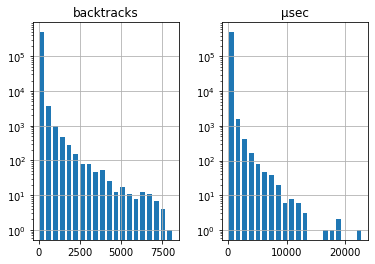

In [18]:
sudata.hist(rwidth=0.7, log=True, bins=20);

For both attributes, almost all the puzzles are in the leftmost bin (the first bar goes almost up to the 5 × 10<sup>5</sup> line; the second bar is more than two horizontal lines down on the log scale, thus more than 100 times smaller). 

Below we zoom in on the puzzles that take 10 backtracks or less. 330,000 out of 500,000 have 10 or less; 189,000 have zero or one backtrack. They all take less than 1/4 millisecond:

In [19]:
quick = sudata[sudata['backtracks'] <= 10]
quick.describe()

,μsec,backtracks
count,330155.000000,330155.000000
mean,48.805696,2.312011
std,10.164409,2.795918
min,34.500000,0.000000
25%,42.100000,0.000000
50%,45.300000,1.000000
75%,52.900000,4.000000
max,245.100000,10.000000


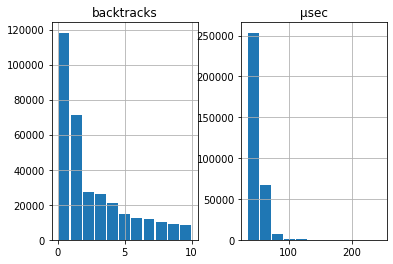

In [20]:
quick.hist(rwidth=.9, bins=11);

# Verifying Correctness

How do we know this program (or any program) is correct? Traditionally, there are four kinds of evidence:
- A large number of example input/output pairs that give the right answer.
- Manual inspection of a smaller number of example input/output pairs.
- A suite of unit tests to verify that components function properly (at least on some inputs).
- A formal roof that the code is correct (or at least an outline of an argument for a partial proof).

For this program:
- Unless `-noverify` is given, every puzzle/solution pair is verified with the `verify` method to make sure:
  - Each square in the solution contains a single digit. 
  - Each unit in the solution contains all nine digits.
  - Squares in the puzzle that are filled with a digit keep that same digit in the solution.
- I have looked at some example solutions and double-checked some with an [online Sudoku](https://sudokuspoiler.azurewebsites.net/) program. [LGTM](https://www.dictionary.com/e/acronyms/lgtm/).
- The `-u` option runs a suite of unit tests.
- I have looked at the code carefully, but I am nowhere near a proof of correctness.


In [21]:
!java Sudoku -u  

Unit tests pass.


You can manually inspect these puzzle/solution pairs:

In [22]:
!java Sudoku -grid -nofile hardest.txt 


Puzzle 1:                   Solution:
8 5 . | . . 2 | 4 . .       8 5 9 | 6 1 2 | 4 3 7 
7 2 . | . . . | . . 9       7 2 3 | 8 5 4 | 1 6 9 
. . 4 | . . . | . . .       1 6 4 | 3 7 9 | 5 2 8 
------+-------+------       ------+-------+------
. . . | 1 . 7 | . . 2       9 8 6 | 1 4 7 | 3 5 2 
3 . 5 | . . . | 9 . .       3 7 5 | 2 6 8 | 9 1 4 
. 4 . | . . . | . . .       2 4 1 | 5 9 3 | 7 8 6 
------+-------+------       ------+-------+------
. . . | . 8 . | . 7 .       4 3 2 | 9 8 1 | 6 7 5 
. 1 7 | . . . | . . .       6 1 7 | 4 2 5 | 8 9 3 
. . . | . 3 6 | . 4 .       5 9 8 | 7 3 6 | 2 4 1 

Puzzle 2:                   Solution:
. . 5 | 3 . . | . . .       1 4 5 | 3 2 7 | 6 9 8 
8 . . | . . . | . 2 .       8 3 9 | 6 5 4 | 1 2 7 
. 7 . | . 1 . | 5 . .       6 7 2 | 9 1 8 | 5 4 3 
------+-------+------       ------+-------+------
4 . . | . . 5 | 3 . .       4 9 6 | 1 8 5 | 3 7 2 
. 1 . | . 7 . | . . 6       2 1 8 | 4 7 3 | 9 5 6 
. . 3 | 2 . . | . 8 .       7 5 3 | 2 9 6 | 4 8 1 
------+

# What's Next?

There are a few things I didn't get a chance to explore; maybe you can:

- Would the program be even faster in Golang or C++ or Rust? Or with some more optimizations?
- The depth-first search makes a choice to *fill* some square with a digit. What if instead the choice was to *eliminate* a digit from the square? At first glance it seems that would be slower, because more choices would be required, but would constraint propagation make it work well?
- On each recursive call, the depth-first search copies the current grid into a new grid (re-using the one in `gridpool[level]`). That requires copying an array of 81 ints. Would it be faster to instead make changes directly to the current grid, and then undo the changes when failure is detected? You would need to keep track of the changes made so that they can be undone. My guess is that this would make the code more complex and not much faster (if any), but you might want to try it.
- In the theory of constraint propagation, [shaving](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.175.7143&rep=rep1&type=pdf) means guessing a value for some variable, detecting a contradiction, and then keeping track of the fact that the value is not possible. But in our program, when we guess wrong we don't keep track of anything. Can the program be made faster by incorporating shaving?
- Can you create an adversarial puzzle, where the program guesses wrong the maximal number of times? In other words, if you draw a tree of choices, what's a puzzle with a tree that has the solution in the bottom-right corner? How much time and how many backtracks does that puzzle take to solve?
- What [other Sudoku strategies](https://bestofsudoku.com/sudoku-strategy) can be implemented? Can you find a suite of strategies that will solve all the puzzles with no search? 
- Can you develop a system to rank the difficulty of puzzles, based on the complexity of the strategies needed to solve it?
- Can you explain the mystery of the outliers?

One final word: I finally got around to writing this up after a friend mentioned to me "*Hey, a while back didn't you do a Sudoku program that could solve like a dozen puzzles a second or something?*" I felt like Robert Wagner when he had to explain to Dr. Evil that "a million dollars isn't exactly a lot of money these days," or in this case "12 Hz isn't exactly a lot of puzzles." So this is for all of you who were cryogenically frozen in 1967 (and for all of you who weren't).

<center>
<img src="https://upload.wikimedia.org/wikipedia/en/1/16/Drevil_million_dollars.jpg">
<br><i>"One <b>dozen</b> puzzles per second"</i>
</center>